In [1]:
%load_ext autoreload

In [2]:
%autoreload
import geopandas as gpd
import pandas as pd
import numpy as np
import fiona
import rasterio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.fill import fillnodata
from rasterio.plot import show
import nexus_tool.weap_tools as wp
import os
import matplotlib.pyplot as plt
from shutil import copyfile
from datetime import date

## Reading files

In [3]:
provinces = gpd.read_file('Data - Souss-Massa/GIS/Admin/Provinces.gpkg')
groundwater = gpd.read_file('Data - Souss-Massa/Schematic/Groundwater.kml')
wwtp = gpd.read_file('Data - Souss-Massa/Schematic/Wastewater Treatment Plants.kml')
other_supply = gpd.read_file('Data - Souss-Massa/Schematic/Other Supplies.kml')
demand_sites = gpd.read_file('Data - Souss-Massa/Schematic/Demand Sites.kml')
catchments = gpd.read_file('Data - Souss-Massa/Schematic/Catchments.kml')
diversion = gpd.read_file('Data - Souss-Massa/Schematic/Diversions.kml')
reservoirs = gpd.read_file('Data - Souss-Massa/Schematic/Reservoirs.kml')
links = gpd.read_file('Data - Souss-Massa/Schematic/Transmission Links.kml')

## Converting geometries and dropping unecesary columns

In [4]:
for gdf in [groundwater, wwtp, other_supply, demand_sites, 
            catchments,diversion, reservoirs, links]:
    gdf['geometry'] = wp.polyz_to_poly(gdf)
    gdf.drop(columns='Description', inplace=True)

In [5]:
for gdf in [groundwater, wwtp, other_supply, 
            reservoirs, demand_sites, catchments]:
    gdf.rename(columns={'Name': 'point'}, inplace=True)

links.rename(columns={'Name': 'links'}, inplace=True)
diversion.rename(columns={'Name': 'diversion'}, inplace=True)

## Defining types

In [6]:
groundwater['type'] = 'Groundwater supply'
wwtp['type'] = 'WWTP'
other_supply['type'] = 'Other supply'
reservoirs['type'] = 'Reservoir supply'
catchments['type'] = 'Catchment'
demand_sites['type'] = 'Demand site'
diversion['type'] = 'Transmission Pipeline'
links['type'] = 'Transmission links'

In [7]:
other_supply['point'] = 'Prelevement 3'
supply_points = groundwater.append([other_supply, reservoirs], ignore_index=True, sort=False)
demand_points = demand_sites.append(catchments, ignore_index=True, sort=False)
links['links'] = links.links.str.replace('Groundwater','GW')
links['links'] = links.links.str.replace('Grounwater','GW')
links['links'] = links.links.str.replace('GW of ','')
links['links'] = links.links.str.replace('GW ','')
links['links'] = links.links.str.strip()

In [8]:
demand_links = gpd.sjoin(demand_points, links, how='inner', op='intersects')
supply_links = gpd.sjoin(supply_points, links, how='inner', op='intersects')

In [9]:
demand_links.rename(columns={'type_left': 'type'}, inplace=True)
demand_links.drop(columns=['type_right'], inplace=True)
supply_links.rename(columns={'type_left': 'type'}, inplace=True)
supply_links.drop(columns=['type_right'], inplace=True)

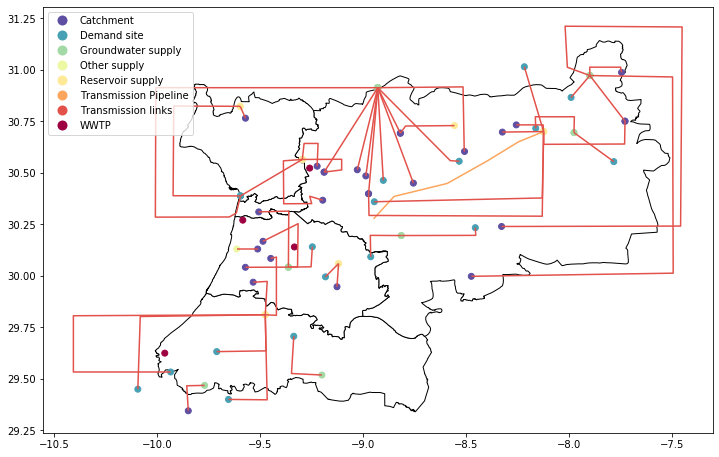

In [10]:
base = provinces.plot(color='white', edgecolor='black', figsize=(12, 12))
data = demand_links.append([supply_links, wwtp, diversion, links], ignore_index=True, sort=False)
data.plot(ax=base, column='type', cmap='Spectral_r', legend=True)
plt.show()

In [11]:
files_dict = {'Reference': {'Eto trend': ['Souss-Massa_Reference.xlsx']}}

def create_folder(path):
    if not os.path.exists(path):
        os.mkdir(path)

raw_data = os.path.join('Data - Souss-Massa', 'WEAP Results')
results_path = os.path.join('Data - Souss-Massa', 'Processed Results')
create_folder(results_path)
for scenario, files in files_dict.items():
    scenario_path = os.path.join(results_path, scenario)
    create_folder(scenario_path)
    for folder, file in files.items():
        folder_path = os.path.join(scenario_path, folder)
        create_folder(folder_path)
        for i, f in enumerate(file):
            dst = os.path.join(folder_path, f'level_{i+1}')
            create_folder(dst)
            copyfile(os.path.join(raw_data, f), os.path.join(dst, 'results.xlsx'))

In [42]:
def integrate_data(sheet_name, category, dff_dict, var_name='links', target='point'):
    df = data.parse(sheet_name, skiprows=3)
    df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
    df.columns = df.columns.str.replace('"', '').str.strip()

    df.columns = df.columns.str.replace('Groundwater','GW')
    df.columns = df.columns.str.replace('Grounwater','GW')
    df.columns = df.columns.str.replace('GW of ','')
    df.columns = df.columns.str.replace('GW ','')

    for link in demand_links.links:
        if np.array(df.columns[df.columns.str.contains(link)]).size > 0:
            df.rename(columns={df.columns[df.columns.str.contains(link)][0]: link}, inplace=True)

    df = df.loc[df.Date!='Sum']
    df.Date = pd.to_datetime(df.Date)
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    
    drop_columns = ['Date']
    if 'Sum' in df.columns:
        drop_columns.append('Sum')
    df.drop(columns=drop_columns, inplace=True)

    df = df.melt(id_vars=['Year', 'Month'])
    
    for name, dff in dff_dict.items():
        df_temp = dff.set_index(var_name)
        if var_name!=target:
            df[name] = df.variable.map(df_temp[target])
    
    df['type'] = category
    df.rename(columns={'variable': var_name}, inplace=True)
#     print(df.loc[~df[var_name].isin(df.dropna()[var_name].unique()),var_name].unique())
    return df

In [45]:
scenarios = ['Reference']
processed_data = os.path.join('Data - Souss-Massa', 'Merged data')
create_folder(processed_data)
for scenario in scenarios:
    scenario_folder = os.path.join(results_path, scenario)
    create_folder(os.path.join(processed_data, scenario))
    for sub_scenario in os.listdir(scenario_folder):
        sub_scenario_folder = os.path.join(scenario_folder, sub_scenario)
        create_folder(os.path.join(processed_data, scenario, sub_scenario))
        for level in os.listdir(sub_scenario_folder):
            output_folder = os.path.join(processed_data, scenario, sub_scenario, level)
            create_folder(output_folder)
            file = os.path.join(sub_scenario_folder, level, 'results.xlsx')
            data = pd.ExcelFile(file)
            
            sheet_names = {'Desalination': 'Desalination plant', 
                           'GP Irrigation': 'Agriculture', 
                           'GP Domestic': 'Domestic',
                           'MAR': 'Aquifer recharge',
                           'SW Irrigation': 'Agriculture',
                           'SW Domestic': 'Domestic'}
            
            df = pd.DataFrame()
            for sheet_name, category in sheet_names.items():
                df = df.append(integrate_data(sheet_name, category, {'Demand point': demand_links, 
                                                                     'Suply point': supply_links}))
            
            df_wwtp = integrate_data('WWTP Inflow', 'wwtp', {'WWTP': wwtp}, 'point', 'point')
            
            df.to_csv(os.path.join(output_folder, 'demand_data.csv'), index=False)
            df_wwtp.to_csv(os.path.join(output_folder, 'wwtp_inflow.csv'), index=False)
            

In [44]:
df

,Year,Month,links,value,Demand point,Suply point,type
0,1976,9,Transmission Link from Desalination to Agadir,0.000,NaN,NaN,Desalination plant
1,1976,10,Transmission Link from Desalination to Agadir,0.000,NaN,NaN,Desalination plant
2,1976,11,Transmission Link from Desalination to Agadir,0.000,NaN,NaN,Desalination plant
3,1976,12,Transmission Link from Desalination to Agadir,0.000,NaN,NaN,Desalination plant
4,1977,1,Transmission Link from Desalination to Agadir,0.000,NaN,NaN,Desalination plant
...,...,...,...,...,...,...,...
2971,2007,4,Transmission Link from Youssef Ben Tachefine t...,654.030,Tiznit,Youssef Ben Tachefine,Domestic
2972,2007,5,Transmission Link from Youssef Ben Tachefine t...,187.153,Tiznit,Youssef Ben Tachefine,Domestic
2973,2007,6,Transmission Link from Youssef Ben Tachefine t...,0.000,Tiznit,Youssef Ben Tachefine,Domestic
2974,2007,7,Transmission Link from Youssef Ben Tachefine t...,0.000,Tiznit,Youssef Ben Tachefine,Domestic


In [46]:
folder = r'Morocco dashboard/spatial_data'
wp.create_folder(folder)
demand_links.to_file(os.path.join(folder, 'Demand_points.geojson'), driver='GeoJSON')
supply_links.to_file(os.path.join(folder, 'Supply_points.geojson'), driver='GeoJSON')
wwtp.to_file(os.path.join(folder, 'wwtp.geojson'), driver='GeoJSON')
diversion.to_file(os.path.join(folder, 'Pipelines.geojson'), driver='GeoJSON')